# Démonstration de l’utilisation de la bibliothèque `pyMDU`

Ce notebook a pour objectif de démontrer comment utiliser la bibliothèque `pymdu`

In [1]:
%matplotlib inline
import os
import sys
from pathlib import Path

import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import rasterio.plot
from matplotlib import rcParams
#from nipype.interfaces.semtools.utilities.brains import landmarksConstellationAlignerOutputSpec
from shapely.geometry import box

%matplotlib inline
rcParams['font.family'] = 'DejaVu Sans'


In [2]:
import os
print(os.getcwd())

/mnt/c/Users/simon/python-scripts/pymdu-public


In [3]:
print(sys.executable)

/home/smartiz/.local/share/mamba/envs/pymdu/bin/python


In [4]:
import h3
print(h3.__file__)



/home/smartiz/.local/lib/python3.11/site-packages/h3/__init__.py


In [5]:
import sys
print(sys.executable.split('/'))
# env_dir = Path.home() / 'miniforge3' / 'envs' / 'pymdu'
# env_dir = Path.home() / 'micromamba'/'envs'/'pymdu'
env_dir = Path.home() / '.local'/'share'/'mamba'/'envs'/'pymdu'

['', 'home', 'smartiz', '.local', 'share', 'mamba', 'envs', 'pymdu', 'bin', 'python']


## Chemin de base vers l'environnement Micromamba / Conda

In [6]:

if sys.platform.startswith('win'):
    # Windows
    proj_lib_path = env_dir / 'Library' / 'share' / 'proj'
    gdalwarp_exe = env_dir / 'Library' / 'bin' / 'gdalwarp.exe'
    gdal_rasterize_exe = env_dir / 'Library' / 'bin' / 'gdal_rasterize.exe'
    bin_dir = env_dir / 'Library' / 'bin'
else:
    # Linux/macOS
    proj_lib_path = env_dir / 'share' / 'proj'
    gdalwarp_exe = env_dir / 'bin' / 'gdalwarp'
    # gdal_rasterize_exe = env_dir / 'bin' / 'gdal_rasterize'
    bin_dir = env_dir / 'bin'

# Application de la configuration
os.environ['PROJ_LIB'] = str(proj_lib_path)
GDALWARP_PATH = str(gdalwarp_exe)

## Chemin de base vers QGIS et ses plugins

In [7]:
if sys.platform.startswith('win'):
    # Windows
    qgis_python = env_dir / 'Library' / 'share' / 'qgis' / 'python'
    qgis_plugins = qgis_python / 'plugins'
    user_plugins = Path.home() / 'AppData' / 'Roaming' / 'QGIS' / 'QGIS3' / 'profiles' / 'default' / 'python' / 'plugins'
else:
    # Linux/macOS
    qgis_python = env_dir / 'share' / 'qgis' / 'python'
    qgis_plugins = qgis_python / 'plugins'
    user_plugins = Path.home() / '.local' / 'share' / 'QGIS' / 'QGIS3' / 'profiles' / 'default' / 'python' / 'plugins'

# Ajout des chemins à sys.path
for path in (qgis_python, qgis_plugins, user_plugins):
    sys.path.append(str(path.resolve()))

## Initialisation du dossier de simulation

In [8]:
inputs_simulation_path = os.path.join(os.getcwd(), 'results_demo/inputs_simulation')
output_path = os.path.join(os.getcwd(), 'results_demo')
os.makedirs(inputs_simulation_path, exist_ok=True)

In [9]:
print(sys.executable)

/home/smartiz/.local/share/mamba/envs/pymdu/bin/python


# Sélection de votre zone d'intérêt

Tracez un rectangle sur la carte ci-dessous pour délimiter la région qui vous intéresse.

Une fois la sélection effectuée, cliquez sur le rectangle et copiez le texte généré.

In [10]:
from pymdu.commons.BasicFunctions import draw_bbox_with_folium

draw_bbox_with_folium(lat=46.160329,
                      lon=-1.151139,
                      zoom_start=13)


TEMP_PATH /tmp


Output()

## Chargement des données GeoJSON et calculer la bounding box

Copiez‐collez le JSON ci-dessous dans la variable `geojson_dict`.

Le script suivant extrait les coordonnées du polygone, détermine les longitudes et latitudes minimales et maximales, puis construit la liste `[minx, miny, maxx, maxy]`.


In [11]:
geojson_dict = {"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-1.155254,46.155467],[-1.155254,46.158503],[-1.148575,46.158503],[-1.148575,46.155467],[-1.155254,46.155467]]]}}
# Extraire les coordonnées du polygone
coordinates = geojson_dict['geometry']['coordinates'][0]
# Calculer les valeurs min et max
minx = min([point[0] for point in coordinates])  # Minimum des longitudes (x)
miny = min([point[1] for point in coordinates])  # Minimum des latitudes (y)
maxx = max([point[0] for point in coordinates])  # Maximum des longitudes (x)
maxy = max([point[1] for point in coordinates])  # Maximum des latitudes (y)
# Créer la liste [minx, miny, maxx, maxy]
bbox_coords = [minx, miny, maxx, maxy]

# Collecter des données


## Bâtiments

In [12]:
from pymdu.geometric.Building import Building

buildings = Building(output_path=inputs_simulation_path)
buildings.bbox = bbox_coords
buildings_gdf = buildings.run().to_gdf()
buildings_gdf.to_file(os.path.join(inputs_simulation_path, "buildings.shp"), driver="ESRI Shapefile")

Index(['Service', 'Thï¿½matique', 'Producteur', 'Nom',
       'URL d'acces Geoportail', 'URL d'acces Geoplateforme',
       'Statut de licence', 'Etat de publication', 'Statut  Gï¿½oplateforme',
       'Date actualisation de la donnï¿½e', 'Remarque'],
      dtype='object')
key=> buildings
['BDTOPO_V3:batiment' 'BDTOPO_V3:batiment']
https://data.geopf.fr/wfs/ows?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetCapabilities
Geo url https://data.geopf.fr/wfs/ows?SERVICE=WFS&VERSION=2.0.0
execute_ign Service WFS public de la Géoplateforme 2.0.0 WFS
typename BDTOPO_V3:batiment


<Axes: >

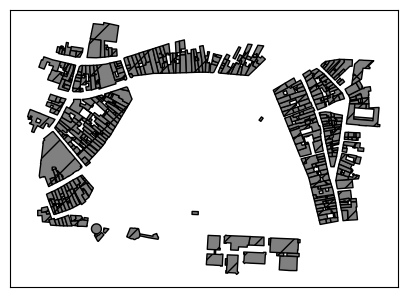

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')

## Couverture du sol avec différentes couches IGN

## Extraction et tracé cartographique des classes `COSIA` : (Couverture du Sol par Intelligence Artificielle)

Tout d’abord, téléchargez les fichiers `COSIA` correspondant à votre zone d’intérêt.

CoSIA - application pour visualiser et télécharger ses cartes de Couverture du Sol par Intelligence Artificielle.

Le lien est disponible ci-dessous.

https://cosia.ign.fr/info#export

Cette cellule importe les fichiers COSIA, calcule l’intersection avec votre zone d’intérêt, puis génère une carte où chaque polygone est coloré d’après sa classe COSIA.


### Cosia avec donnée brute GeoPackage

In [16]:
print(sys.executable)
from pathlib import Path
from pymdu.geometric.Cosia import Cosia
# directory_path = Path.home() / 'Downloads/CoSIA_D017_2021'
directory_path = r"/mnt/c/Users/simon/cosia/CoSIA_D017_2021"
cosia = Cosia(directory_path_cosia=directory_path)
cosia.bbox = bbox_coords
cosia_gdf = cosia.run()
table_color_cosia = cosia.table_color_cosia
cosia_gdf['color'] = [table_color_cosia[x] for x in cosia_gdf.classe]

/home/smartiz/.local/share/mamba/envs/pymdu/bin/python
Index(['Service', 'Thï¿½matique', 'Producteur', 'Nom',
       'URL d'acces Geoportail', 'URL d'acces Geoplateforme',
       'Statut de licence', 'Etat de publication', 'Statut  Gï¿½oplateforme',
       'Date actualisation de la donnï¿½e', 'Remarque'],
      dtype='object')


<Axes: >

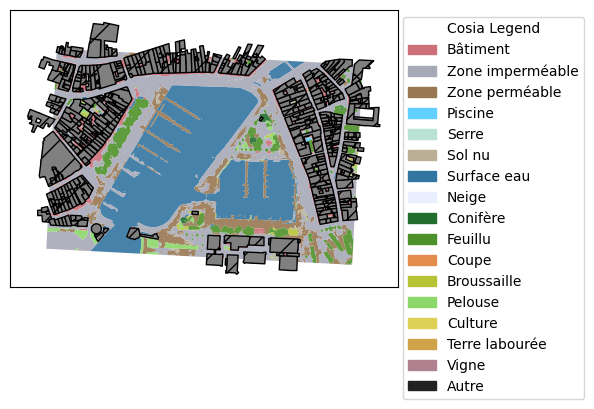

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

# Créer les patches pour chaque couleur et sa description dans la légende
patches = [
    mpatches.Patch(color=value, label=label)
    for (value, label) in zip(table_color_cosia.values(), table_color_cosia.keys())
]

# Ajouter la légende personnalisée
plt.legend(
    handles=patches,
    loc="upper right",
    title="Cosia Legend",
    bbox_to_anchor=(1.5, 1.)
)
ax.set_xticks([])
ax.set_yticks([])
cosia_gdf.plot(ax=ax, edgecolor=None, color=cosia_gdf['color'], alpha=0.9)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')


### Cosia avec donnée IGN

In [18]:
# import rasterio
# from rasterio.features import shapes
# import geopandas as gpd
# from shapely.geometry import shape

# cosia_ign = cosia.run_ign()

# with rasterio.open(cosia.path_save_tiff) as src:
#     band1 = src.read(1)
#     band2 = src.read(2)
#     band3 = src.read(3)
#     mask = band1 != src.nodata  # ignorer les valeurs nodata

#     results = (
#         {'properties': {'value': v}, 'geometry': s}
#         for s, v in shapes(band1, mask=mask, transform=src.transform)
#     )

#     # Créer un GeoDataFrame à partir des résultats
#     geoms = []
#     values = []
#     for result in results:
#         geoms.append(shape(result['geometry']))
#         values.append(result['properties']['value'])

# cosia_gdf_ign = gpd.GeoDataFrame({'value': values, 'geometry': geoms}, crs=src.crs)

# # Afficher un aperçu
# cosia_gdf_ign.head(100)

In [19]:
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.set_xticks([])
# ax.set_yticks([])
# cosia_gdf_ign.plot(ax=ax, edgecolor=None, column='value', alpha=0.9)
# buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')

## Couverture du sol avec différentes avec `COSIA`

In [20]:
from pymdu.geometric.LandCover import LandCover


os.makedirs(output_path, exist_ok=True)

landcover = LandCover(output_path=output_path,
                      building_gdf=None,
                      vegetation_gdf=None,
                      cosia_gdf=cosia_gdf,
                      dxf_gdf=None,
                      pedestrian_gdf=None,
                      water_gdf=None)

landcover_gdf = landcover.run(keep_geom_type=True).to_gdf()
landcover.bbox = bbox_coords
landcover.to_shp(name='landcover')

landcover.create_landcover_from_cosia(os.path.join(inputs_simulation_path, "landcover.tif"))

<Axes: title={'center': 'Landcover (Cosia)'}>

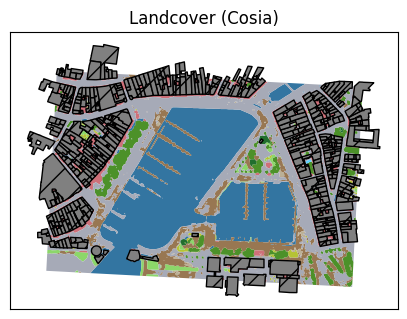

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
plt.title('Landcover (Cosia)')
landcover.gdf.plot(ax=ax, color=landcover_gdf["color"], alpha=1)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')

## Création de la couche `DEM` : (Digital Elevation Model)

Dans cette section, nous procédons à la création de la couche DEM (Digital Elevation Model), qui représente le modèle numérique de terrain pour la zone d'étude. Les données nécessaires à la construction de cette couche sont téléchargées à partir du serveur de l'IGN (Institut Géographique National), garantissant ainsi une haute précision et une couverture complète du territoire concerné.


Le DEM ne prend pas en compte les objets présents à la surface du terrain tels que les plantes et les bâtiments.

In [20]:
from pymdu.geometric.Dem import Dem

dem = Dem(output_path=inputs_simulation_path)
dem.bbox = bbox_coords
dem.run()

Index(['Service', 'Thï¿½matique', 'Producteur', 'Nom',
       'URL d'acces Geoportail', 'URL d'acces Geoplateforme',
       'Statut de licence', 'Etat de publication', 'Statut  Gï¿½oplateforme',
       'Date actualisation de la donnï¿½e', 'Remarque'],
      dtype='object')
key=> dem
['ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES'
 'ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES']
https://data.geopf.fr/wms-r/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities
URL  :  /tmp/dem.tiff


ERROR 1: _TIFFVSetField:/tmp/dem.tiff: Null count for "GeoDoubleParams" (type 12, writecount -1, passcount 1)


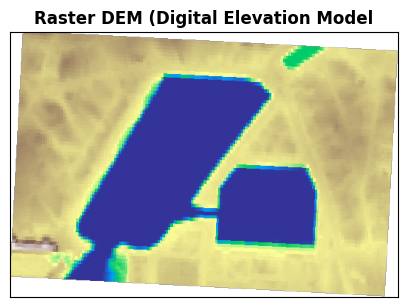

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(inputs_simulation_path, "DEM.tif"))
im = rasterio.plot.show(raster, ax=ax, title="Raster DEM (Digital Elevation Model", cmap='terrain')
# Ajouter la barre de couleur
# fig.colorbar(im, ax=ax, orientation='vertical', label='Elevation')
plt.show()

## Découpage et reprojection du DEM avec GDAL

In [22]:
import subprocess

inraster = os.path.join(inputs_simulation_path, "DEM.tif")
outraster = os.path.join(output_path, "DEM.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")
subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])

Creating output file that is 453P x 309L.
Using internal nodata values (e.g. -99999) for image /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DEM.tif.
Copying nodata values from source /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DEM.tif to destination /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/DEM.tif.
Processing /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DEM.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


0

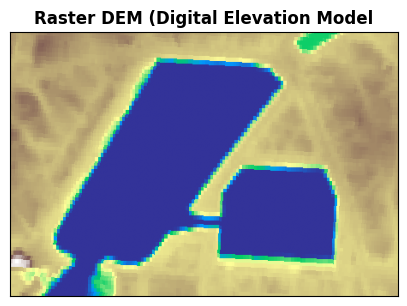

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "DEM.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster DEM (Digital Elevation Model", cmap='terrain')
plt.show()

## Homégénéisation des rasters

Dans cette étape, nous procédons à l'homogénéisation des rasters utilisés pour les différentes couches géospatiales. Lors de la manipulation des données raster, les différences de projections peuvent entraîner des décalages spatiaux entre les couches, ce qui pourrait compromettre la précision des analyses.

Pour garantir que les résultats des simulations soient cohérents et fiables, il est essentiel de s'assurer que tous les rasters ont la même taille et les mêmes dimensions.


In [24]:
from osgeo import gdal, gdalconst
from pymdu.image.geotiff import raster_file_like

gdal.AllRegister()
warp_options = gdal.WarpOptions(format='GTiff',
                                xRes=1, yRes=1,
                                outputType=gdalconst.GDT_Float32,
                                dstNodata=None,
                                dstSRS='EPSG:2154',
                                cropToCutline=True,
                                cutlineDSName=os.path.join(inputs_simulation_path, 'mask.shp'),
                                cutlineLayer='mask')

gdal.Warp(destNameOrDestDS=os.path.join(output_path, 'landcover_clip.tif'),
          srcDSOrSrcDSTab=os.path.join(inputs_simulation_path, 'landcover.tif'),
          options=warp_options)

raster_file_like(src_tif=os.path.join(output_path, "landcover_clip.tif"),
                 dst_tif=os.path.join(output_path, "landcover.tif"),
                 like_path=os.path.join(output_path, "DEM.tif"),
                 remove_nan=True)

Pas besoin de re-découper


<xarray.DataArray (band: 1, y: 309, x: 453)> Size: 560kB
array([[[2., 2., ..., 2., 2.],
        [2., 2., ..., 2., 2.],
        ...,
        [1., 1., ..., 6., 6.],
        [1., 1., ..., 6., 6.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 3.795e+05 3.795e+05 ... 3.8e+05 3.8e+05
  * y            (y) float64 2kB 6.57e+06 6.57e+06 ... 6.57e+06 6.57e+06
    spatial_ref  int64 8B 0
Attributes:
    long_name:      type
    name:           type
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

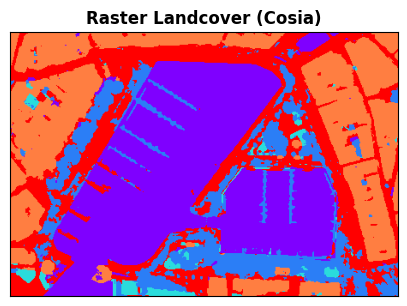

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "landcover.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster Landcover (Cosia)", cmap='rainbow_r')
plt.show()

## Extraction des arbres à partir de données LiDAR

Le LiDAR (Light Detection And Ranging) est une méthode de télédétection par laser qui fournit un nuage de points 3D extrêmement précis de la surface du sol et de la végétation.

Dans cette étape, nous exploitons ces données pour détecter les arbres au sein de notre zone d’intérêt.
Avec la classe `Lidar` de `pymdu` :
- Nous chargeons les données LiDAR,
- Appliquons la bounding box définie précédemment,
- Exécutons l’algorithme de détection des arbres,
- Et exportons les emplacements des arbres sous forme de shapefile.

In [26]:
from pymdu.image.Lidar import Lidar

lidar = Lidar(output_path=inputs_simulation_path)
lidar.bbox = bbox_coords
lidar_tif = lidar.to_tif(write_out_file=True, classification_list=[3, 4, 5, 9])

<Response [200]>


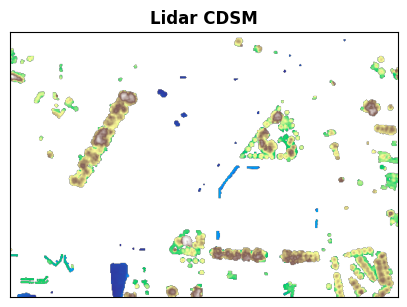

In [27]:
# Lire les données et les afficher avec rasterio.plot
with lidar_tif.open() as src:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks([])
    ax.set_yticks([])
    rasterio.plot.show(src, ax=ax, title="Lidar CDSM", cmap='terrain')
    plt.show()

In [28]:
lidar_trees_gdf = lidar.run_trees()
lidar_trees_gdf.to_file(os.path.join(inputs_simulation_path, 'lidar_trees.shp'))

<Response [200]>
Projected BBOX (EPSG:2154): [379469.14715032035, 380001.58724372747, 6570174.188856954, 6570483.784653486]
DSM.tif saved successfully.
DTM.tif saved successfully.
CHM.tif saved successfully.
Detected 32 tree top candidates.
Extracted 32 crown polygons.
Tree crowns saved to 'tree_crowns.shp'.
Tree tops saved to 'tree_tops.shp'.


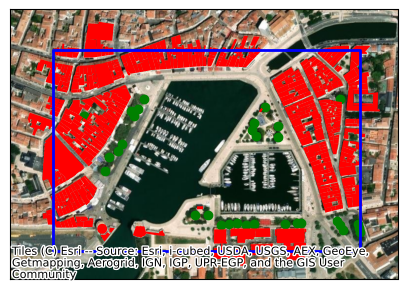

In [30]:
# 1. Create the bbox polygon in WGS84 (EPSG:4326)
import geopandas as gpd
bbox_poly = gpd.GeoSeries([box(*bbox_coords)], crs="EPSG:4326")

# 2. Convert all layers to Web Mercator (EPSG:3857)
lidar_trees_3857 = lidar_trees_gdf.to_crs(epsg=3857)
buildings_3857 = buildings_gdf.to_crs(epsg=3857)
bbox_3857 = bbox_poly.to_crs(epsg=3857)

# 3. Plot everything, including the bbox
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])

lidar_trees_3857.plot(ax=ax, color='g', alpha=1)
buildings_3857.plot(ax=ax, color='r', alpha=1)
bbox_3857.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

plt.show()


# Utilisation automatique du plugin UMEP de QGIS

 1. Télécharger https://github.com/UMEP-dev/UMEP-processing -> renommer processing_umep
 2. Coller dans le répertoire : `.local/share/QGIS/QGIS3/profiles/default/python/plugins` ou

`[...]/envs/pymdu/share/qgis/python/plugins`


## Construction de la couche `DSM` : (Digital Surface Model)

Dans cette étape, nous procédons à la construction de la couche `DSM` (Digital Surface Model), qui est représentée par le fichier `DSM.tif`.

Dans le cadre du code `Solweig`, cette couche joue un rôle essentiel car elle représente la hauteur des éléments présents à la surface, tels que les bâtiments, la végétation, et autres structures. Contrairement au modèle numérique de terrain (DEM) qui ne prend en compte que la topographie du sol, le DSM inclut l'élévation des objets se trouvant au-dessus du sol.

In [31]:
from pymdu.physics.umep.DsmModelGenerator import DsmModelGenerator

dsm = DsmModelGenerator(
    working_directory=inputs_simulation_path,
    output_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),
    input_filepath_dem=os.path.join(inputs_simulation_path, "DEM.tif"),
    input_building_shp_path=os.path.join(inputs_simulation_path, "buildings.shp"),
    input_mask_shp_path=os.path.join(inputs_simulation_path, "mask.shp")

)
dsm.run()

inraster = os.path.join(inputs_simulation_path, f"DSM.tif")
outraster = os.path.join(output_path, f"DSM.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")

subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])

__init__ QGisCore
__init__ qgsApp
platform.system() Linux


QStandardPaths: wrong permissions on runtime directory /mnt/wslg/runtime-dir, 0777 instead of 0700


__init__ UmepCore
extent 379509.0801573259,379961.654236722,6570174.3817853825,6570483.590226259 [EPSG:2154]


/home/smartiz/.local/share/QGIS/QGIS3/profiles/default/python/plugins/processing_umep/processor/shadow_generator_algorithm.py:334: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if outputDir is 'None':
/home/smartiz/.local/share/QGIS/QGIS3/profiles/default/python/plugins/processing_umep/functions/SOLWEIGpython/Solweig_run.py:141: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if configDict['filepath_tdsm'] is not '':
/home/smartiz/.local/share/QGIS/QGIS3/profiles/default/python/plugins/processing_umep/functions/SOLWEIGpython/Solweig_run.py:270: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if configDict['poi_file'] is not '': # usePOI:
/home/smartiz/.local/share/QGIS/QGIS3/profiles/default/python/plugins/processing_umep/functions/URock/H2gisConnection.py:296: DeprecationWarning: invalid escape sequence '\.'
  tempo_split = re.split('\.|\-', v)
/home/smartiz/.local/share/mamba/envs/pymdu/lib/python3.11/site-packages/jaydebeapi/__init__.py:188: Depr

Processing UMEP umep:Spatial Data: DSM Generator
{'INPUT_DEM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DEM.tif', 'INPUT_POLYGONLAYER': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/buildings.shp', 'INPUT_FIELD': 'hauteur', 'USE_OSM': False, 'BUILDING_LEVEL': 3.1, 'EXTENT': '379509.0801573259,379961.654236722,6570174.3817853825,6570483.590226259 [EPSG:2154]', 'PIXEL_RESOLUTION': 1, 'OUTPUT_DSM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DSM.tif'}
Processing UMEP EXIT umep:Spatial Data: DSM Generator
Creating output file that is 453P x 309L.
Using internal nodata values (e.g. -9999) for image /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DSM.tif.
Copying nodata values from source /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DSM.tif to destination /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/DSM.tif.
Pr

0

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "DSM.tif"))
img = rasterio.plot.show(raster, ax=ax, title="Raster DSM (Digital Surface Model)", cmap='terrain')
plt.show()

## Construction de la couche `CDSM` et `TDSM`

Dans cette étape, nous procédons à la construction des couches `CDSM` (Canopy Digital Surface Model) et `TDSM` (Tree Digital Surface Model), qui sont essentielles pour les simulations dans le cadre du code `Solweig`. La couche `CDSM` représente un modèle numérique de surface spécifique à la canopée urbaine, c'est-à-dire les éléments au-dessus du sol qui ne sont pas des bâtiments, principalement des haies et le tronc des arbres.

De son côté, la couche `TDSM` est dédiée à la représentation des arbres. Elle modélise l'élévation des arbres, ce qui permet d'analyser leur contribution à la régulation thermique et à la réduction des îlots de chaleur en milieu urbain.


In [34]:
from pymdu.physics.umep.SurfaceModelGenerator import SurfaceModelGenerator

trees_path = os.path.join(inputs_simulation_path, 'lidar_trees.shp')

surface_model = SurfaceModelGenerator(
    working_directory=inputs_simulation_path,
    input_filepath_dsm=os.path.join(output_path, "DSM.tif"),
    input_filepath_dem=os.path.join(output_path, "DEM.tif"),
    input_filepath_tree_shp=trees_path,
    output_filepath_cdsm=os.path.join(inputs_simulation_path, "CDSM.tif"),
    output_filepath_tdsm=os.path.join(inputs_simulation_path, "TDSM.tif")
)
surface_model.run()
list_files = ['CDSM', 'TDSM']

for file in list_files:
    inraster = os.path.join(inputs_simulation_path, f"{file}.tif")
    outraster = os.path.join(output_path, f"{file}.tif")
    inshape = os.path.join(inputs_simulation_path, "mask.shp")

    subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                     '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                     'Float32'])

__init__ QGisCore
__init__ qgsApp


QStandardPaths: wrong permissions on runtime directory /mnt/wslg/runtime-dir, 0777 instead of 0700


platform.system() Linux
__init__ UmepCore
Processing UMEP umep:Spatial Data: Tree Generator
{'INPUT_POINTLAYER': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/lidar_trees.shp', 'TREE_TYPE': 'type', 'TOT_HEIGHT': 'height', 'TRUNK_HEIGHT': 'trunk zone', 'DIA': 'diameter', 'INPUT_BUILD': None, 'INPUT_DSM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/DSM.tif', 'INPUT_DEM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/DEM.tif', 'INPUT_CDSM': None, 'INPUT_TDSM': None, 'CDSM_GRID_OUT': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/CDSM.tif', 'TDSM_GRID_OUT': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/TDSM.tif'}
Processing UMEP EXIT umep:Spatial Data: Tree Generator
Creating output file that is 453P x 309L.
Processing /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/CDSM.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...1

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(inputs_simulation_path, "CDSM.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster CDSM (Canopy Digital Surface Model)", cmap='terrain')
plt.show()

## Construction de la couche `HEIGHT` et `ASPECT`

Dans cette étape, nous procédons à la construction des couches `HEIGHT` et `ASPECT`, qui jouent un rôle crucial dans les simulations climatiques effectuées avec le code `Solweig`.

La couche `HEIGHT` représente la hauteur des structures urbaines, telles que les bâtiments, par rapport au niveau du sol. Cette information est fondamentale pour évaluer l'impact des différentes hauteurs sur la distribution des ombres, la répartition des rayonnements solaires, et, par conséquent, sur la température ressentie dans l'environnement urbain.

La couche `ASPECT`, indique l'orientation des pentes et des surfaces par rapport aux points cardinaux. Cette orientation est essentielle pour comprendre comment les surfaces captent ou réfléchissent la lumière du soleil tout au long de la journée, influençant directement la distribution des températures et des conditions microclimatiques au sein du quartier.


In [36]:
from pymdu.physics.umep.HeightAspectModelGenerator import HeightAspectModelGenerator

height_aspect_model = HeightAspectModelGenerator(
    working_directory=inputs_simulation_path,
    output_filepath_height=os.path.join(inputs_simulation_path, "HEIGHT.tif"),
    output_filepath_aspect=os.path.join(inputs_simulation_path, "ASPECT.tif"),
    input_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),

)
height_aspect_model.run()

list_files = ['HEIGHT', 'ASPECT']

for file in list_files:
    inraster = os.path.join(inputs_simulation_path, f"{file}.tif")
    outraster = os.path.join(output_path, f"{file}.tif")
    inshape = os.path.join(inputs_simulation_path, "mask.shp")

    subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                     '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                     'Float32'])


__init__ QGisCore
__init__ qgsApp


QStandardPaths: wrong permissions on runtime directory /mnt/wslg/runtime-dir, 0777 instead of 0700


platform.system() Linux
__init__ UmepCore
Processing UMEP umep:Urban Geometry: Wall Height and Aspect
{'INPUT': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DSM.tif', 'INPUT_LIMIT': 3, 'OUTPUT_HEIGHT': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/HEIGHT.tif', 'OUTPUT_ASPECT': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/ASPECT.tif'}
Processing UMEP EXIT umep:Urban Geometry: Wall Height and Aspect
Creating output file that is 453P x 309L.
Processing /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/HEIGHT.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 453P x 309L.
Processing /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/ASPECT.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "ASPECT.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster ASPECT", cmap='binary')
plt.show()

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "HEIGHT.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster HEIGHT", cmap='binary')
plt.show()

## Construction de la couche `SkyViewFactor`

Dans cette étape, nous procédons à la construction de la couche `SkyViewFactor`, qui est une composante essentielle pour les simulations climatiques dans le cadre du code `Solweig`. Le Sky View Factor (SVF) est un indicateur qui mesure la proportion du ciel visible depuis un point donné au sol. Il est particulièrement important dans les environnements urbains denses, où les bâtiments et autres structures peuvent obstruer la vue du ciel, réduisant ainsi l'exposition au rayonnement solaire direct et affectant la température ressentie.

`Solweig` se distingue par sa capacité à utiliser des Sky View Factors directionnels, ce qui signifie qu'il prend en compte la visibilité du ciel dans différentes directions (nord, sud, est, ouest) pour chaque point de la zone étudiée. Cette approche directionnelle permet une modélisation plus fine des interactions entre les bâtiments, les ombres, et le climat urbain.


In [39]:
from pymdu.physics.umep.SVFModelGenerator import SVFModelGenerator

svf_model = SVFModelGenerator(
    working_directory=output_path,
    input_filepath_tdsm=os.path.join(inputs_simulation_path, "TDSM.tif"),
    input_filepath_cdsm=os.path.join(inputs_simulation_path, "CDSM.tif"),
    input_filepath_dsm=os.path.join(inputs_simulation_path, "DSM.tif"),
    ouptut_filepath_svf=os.path.join(inputs_simulation_path, "SVF.tif"),
)
svf_model.run()

inraster = os.path.join(inputs_simulation_path, "SVF.tif")
outraster = os.path.join(output_path, "SVF_clip.tif")
inshape = os.path.join(inputs_simulation_path, "mask.shp")

subprocess.call([GDALWARP_PATH, inraster, outraster, '-cutline', inshape,
                 '-crop_to_cutline', '-overwrite', '-of', 'GTIFF', '-t_srs', 'EPSG:2154', '-tr', '1', '1', '-ot',
                 'Float32'])


__init__ QGisCore
__init__ qgsApp


QStandardPaths: wrong permissions on runtime directory /mnt/wslg/runtime-dir, 0777 instead of 0700


platform.system() Linux
__init__ UmepCore
Processing UMEP umep:Urban Geometry: Sky View Factor
{'INPUT_DSM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/DSM.tif', 'INPUT_CDSM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/CDSM.tif', 'TRANS_VEG': 3, 'INPUT_TDSM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/TDSM.tif', 'INPUT_THEIGHT': 25.0, 'ANISO': True, 'OUTPUT_DIR': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo', 'OUTPUT_FILE': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/SVF.tif'}
Processing UMEP EXIT umep:Urban Geometry: Sky View Factor
Creating output file that is 453P x 309L.
Using internal nodata values (e.g. -9999) for image /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/SVF.tif.
Copying nodata values from source /mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/inputs_simulation/SVF.tif 

0

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "SVF_clip.tif"))
rasterio.plot.show(raster, ax=ax, title="Raster SVF (Sky View Factor)", cmap='gray')
plt.show()

## Météo

In [41]:
from pymdu.meteo.Meteo import Meteo

meteo_file = Meteo(output_path=r"./")
meteo_file.bbox = bbox_coords
meteo_file.run(
        begin='2018-06-30 00:00:00',
        end='2018-06-30 23:00:00'
    )


## Calcul de la température moyenne radiante

In [42]:
from pymdu.physics.umep.Solweig import Solweig

d = Solweig(meteo_path='FRA_AC_La.Rochelle.073150_TMYx.2004-2018.txt',
            output_dir=output_path,
            working_directory=output_path,
            input_filepath_landcover=os.path.join(output_path, "landcover.tif"),
            input_filepath_dsm=os.path.join(output_path, "DSM.tif"),
            input_filepath_dem=os.path.join(output_path, "DEM.tif"),
            input_filepath_cdsm=os.path.join(output_path, "CDSM.tif"),
            input_filepath_tdsm=os.path.join(output_path, "TDSM.tif"),
            input_filepath_height=os.path.join(output_path, "HEIGHT.tif"),
            input_filepath_aspect=os.path.join(output_path, "ASPECT.tif"),
            input_filepath_shadowmats_npz=os.path.join(output_path, "shadowmats.npz"),
            input_filepath_svf_zip=os.path.join(output_path, "svfs.zip"))
d.run()



__init__ QGisCore
__init__ qgsApp
platform.system() Linux
__init__ UmepCore


QStandardPaths: wrong permissions on runtime directory /mnt/wslg/runtime-dir, 0777 instead of 0700


Processing UMEP umep:Outdoor Thermal Comfort: SOLWEIG
{'INPUT_DSM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/DSM.tif', 'INPUT_SVF': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/svfs.zip', 'INPUT_HEIGHT': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/HEIGHT.tif', 'INPUT_ASPECT': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/ASPECT.tif', 'INPUT_CDSM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/CDSM.tif', 'TRANS_VEG': 3, 'INPUT_TDSM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/TDSM.tif', 'INPUT_THEIGHT': 25, 'INPUT_LC': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/landcover.tif', 'USE_LC_BUILD': False, 'INPUT_DEM': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/DSM.tif', 'SAVE_BUILD': False, 'INPUT_ANISO': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/shadowmats.npz', 'ALBEDO_WALLS': 0.2, 'ALBEDO_GROUND': 0.15, 'EMIS_WALLS': 0.9, 'EMIS_GROUND':

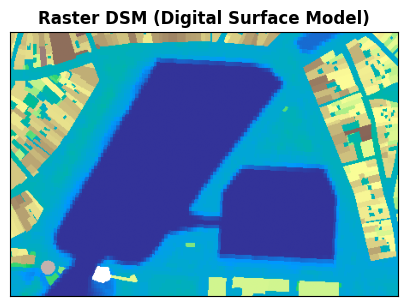

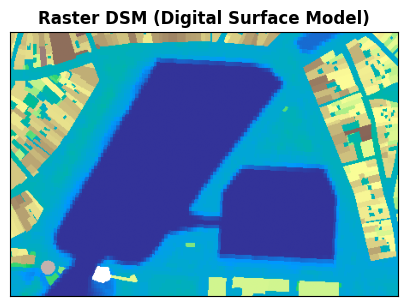

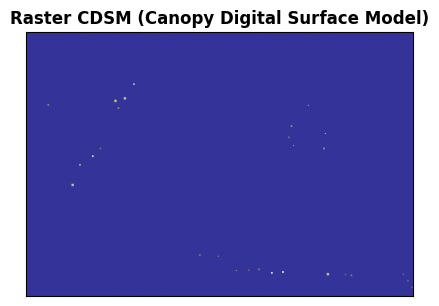

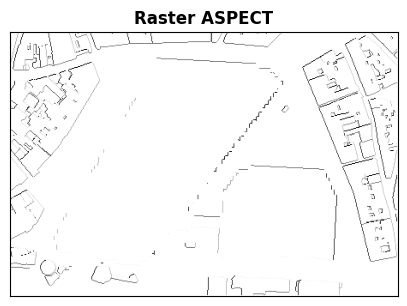

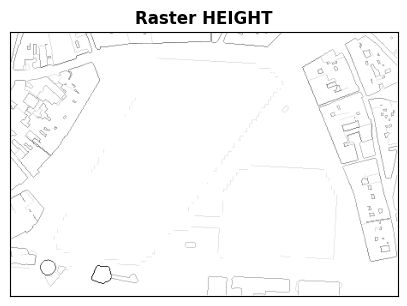

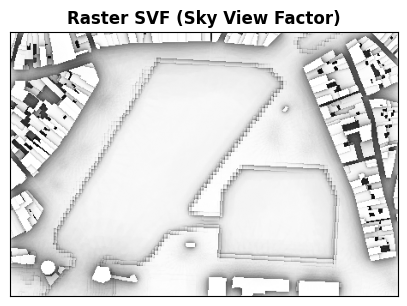

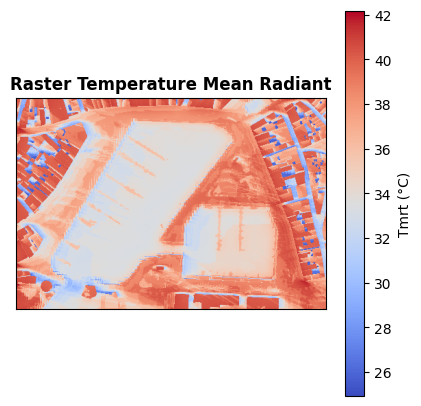

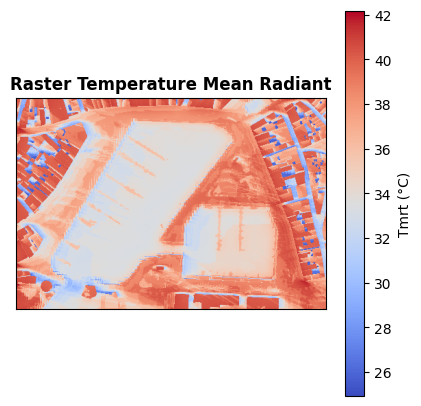

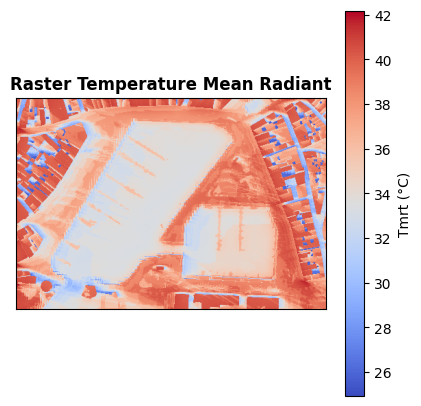

In [45]:

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
raster = rasterio.open(os.path.join(output_path, "Tmrt_average.tif"))
img = rasterio.plot.show(raster, ax=ax, title="Raster Temperature Mean Radiant", cmap='coolwarm')
plt.colorbar(img.get_images()[0], ax=ax, label='Tmrt (°C)')
plt.show()

## Lancement UROCK : (Urban Wind Field)

In [21]:
import geopandas as gpd
from pymdu.geometric.UrockFiles import UrockFiles

batiments = gpd.read_file(os.path.join(inputs_simulation_path, 'buildings.shp'))
arbres = gpd.read_file(os.path.join(inputs_simulation_path, 'lidar_trees.shp'))

urock = UrockFiles(output_path, batiments, arbres)
urock.generate_urock_buildings().to_file(os.path.join(output_path, 'batiments_urock.shp'), driver="ESRI Shapefile")
urock.generate_urock_trees().to_file(os.path.join(output_path, 'arbres_urock.shp'), driver="ESRI Shapefile")

In [ ]:
output_path_urock = os.path.join(output_path, 'output_urock')
os.makedirs(output_path_urock, exist_ok=True)

from pymdu.physics.umep.UmepCore import UmepCore

for direction in range(50, 55, 10):
    options_umep_urock = {
        'BUILDINGS': os.path.join(output_path, 'batiments_urock.shp'),
        'HEIGHT_FIELD_BUILD': 'hauteur',
        'VEGETATION': os.path.join(output_path, 'arbres_urock.shp'),
        'VEGETATION_CROWN_TOP_HEIGHT': 'MAX_HEIGHT',
        'VEGETATION_CROWN_BASE_HEIGHT': 'MIN_HEIGHT',
        'ATTENUATION_FIELD': 'ATTENUATIO',
        'INPUT_PROFILE_FILE': '',
        'INPUT_PROFILE_TYPE': 0,
        'INPUT_WIND_HEIGHT': 10,
        'INPUT_WIND_SPEED': 1,
        'INPUT_WIND_DIRECTION': direction,
        'RASTER_OUTPUT': None,
        'HORIZONTAL_RESOLUTION': 1,
        'VERTICAL_RESOLUTION': 10,
        'WIND_HEIGHT': '2',
        'UROCK_OUTPUT': output_path_urock,
        'OUTPUT_FILENAME': f'output_{direction}',
        'SAVE_RASTER': False,
        'SAVE_VECTOR': False,
        'SAVE_NETCDF': True,
        'LOAD_OUTPUT': True
    }

    umep_core = UmepCore(output_dir=output_path_urock)

    umep_core.run_processing(
        name="umep:Urban Wind Field: URock",
        options=options_umep_urock
    )

__init__ QGisCore
__init__ qgsApp
platform.system() Linux


QStandardPaths: wrong permissions on runtime directory /mnt/wslg/runtime-dir, 0777 instead of 0700


__init__ UmepCore


/home/smartiz/.local/share/mamba/envs/pymdu/share/qgis/python/plugins/processing_umep/processor/shadow_generator_algorithm.py:334: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if outputDir is 'None':
/home/smartiz/.local/share/mamba/envs/pymdu/share/qgis/python/plugins/processing_umep/functions/SOLWEIGpython/Solweig_run.py:141: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if configDict['filepath_tdsm'] is not '':
/home/smartiz/.local/share/mamba/envs/pymdu/share/qgis/python/plugins/processing_umep/functions/SOLWEIGpython/Solweig_run.py:270: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if configDict['poi_file'] is not '': # usePOI:
/home/smartiz/.local/share/mamba/envs/pymdu/share/qgis/python/plugins/processing_umep/functions/URock/H2gisConnection.py:296: DeprecationWarning: invalid escape sequence '\.'
  tempo_split = re.split('\.|\-', v)
<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incomp

Processing UMEP umep:Urban Wind Field: URock
{'BUILDINGS': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/batiments_urock.shp', 'HEIGHT_FIELD_BUILD': 'hauteur', 'VEGETATION': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/arbres_urock.shp', 'VEGETATION_CROWN_TOP_HEIGHT': 'MAX_HEIGHT', 'VEGETATION_CROWN_BASE_HEIGHT': 'MIN_HEIGHT', 'ATTENUATION_FIELD': 'ATTENUATIO', 'INPUT_PROFILE_FILE': '', 'INPUT_PROFILE_TYPE': 0, 'INPUT_WIND_HEIGHT': 10, 'INPUT_WIND_SPEED': 1, 'INPUT_WIND_DIRECTION': 50, 'RASTER_OUTPUT': None, 'HORIZONTAL_RESOLUTION': 1, 'VERTICAL_RESOLUTION': 10, 'WIND_HEIGHT': '2', 'UROCK_OUTPUT': '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/output_urock', 'OUTPUT_FILENAME': 'output_50', 'SAVE_RASTER': False, 'SAVE_VECTOR': False, 'SAVE_NETCDF': True, 'LOAD_OUTPUT': True}
Connecting to database
	->/tmp/URock_2025-07-30T16482062d7913d-8671-445f-9489-fd8b99a076c4/myDbH21753886900_5891247
/home/smartiz/.local/share/mamba/envs/pymdu/share/qgis

SLF4J(W): No SLF4J providers were found.
SLF4J(W): Defaulting to no-operation (NOP) logger implementation
SLF4J(W): See https://www.slf4j.org/codes.html#noProviders for further details.


Spatial functions added!

Load input data
Load table 'build_pre_srid_20250730164821'
Load table 'veg_pre_srid_20250730164821'
Creates blocks and stacked blocks
Rotates geometries from 50.0 degrees
Identify block base height and block cavity base
Calculates obstacle properties
Calculates zone properties
Initializes upwind facades
Update upwind facades base height
Initializes downwind facades
Calculates study area properties
Roughness zone properties are:

                                 - z0: 1.047153274829286
                                 - d: 3.9919842232129117
                                 - Hr: 14.13887030678529
                                 - H_ob_max: 30.0
                                 - lambda_f: 0.07406201854236924
Rotates geometries from -50.0 degrees
Creates displacement zones
Creates cavity and wake zones
Creates street canyon zones
Creates rooftop zones (perpendicular and corner)
Creates built-up and open vegetation zones
Creates the grid of points
Affects each 

## Post-traitement :  Tif to netCDF


In [48]:
import numpy as np
import rasterio
from pyproj import Transformer

import os

TMRT_PATH = os.path.join(output_path, 'Tmrt_average.tif')
with rasterio.open(TMRT_PATH) as tif:
    temp = tif.read(1)
    tif_transform = tif.transform
    tif_crs = tif.crs
    tif_width = tif.width
    tif_height = tif.height
    print('tif crs, tif transform', tif_crs, tif_transform)
    print('tif width, tif height:', tif_width, tif_height)

    rows, cols = np.meshgrid(np.arange(tif_height), np.arange(tif_width), indexing='ij')
    xs, ys = rasterio.transform.xy(tif_transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

# Flatten for reprojection
xs_flat = xs.flatten()
ys_flat = ys.flatten()

# Set up a transformer from EPSG:2154 to WGS84
transformer = Transformer.from_crs(tif_crs, "EPSG:4326", always_xy=True)
lons_flat, lats_flat = transformer.transform(xs_flat, ys_flat)

# Reshape to tif grid shape
lons = lons_flat.reshape(xs.shape)
lats = lats_flat.reshape(ys.shape)


tif crs, tif transform EPSG:2154 | 1.00, 0.00, 379509.08|
| 0.00,-1.00, 6570483.59|
| 0.00, 0.00, 1.00|
tif width, tif height: 453 309


In [49]:
from netCDF4 import Dataset
import numpy as np

direction = 50
file_name = f'output_{direction}.nc'
file_nc = os.path.join(output_path_urock, file_name)

nc = Dataset(file_nc)
group = nc.groups['3D_wind']

lon = group.variables['lon'][:]
lat = group.variables['lat'][:]

Z = group.variables['Z'][:]
level_idx = np.argmin(np.abs(Z - 10))  # 10 meter

wind_x = group.variables['windSpeed_x'][:, :, level_idx]
wind_y = group.variables['windSpeed_y'][:, :, level_idx]
wind_z = group.variables['windSpeed_z'][:, :, level_idx]

wind_speed = np.sqrt(wind_x ** 2 + wind_y ** 2 + wind_z ** 2)

# flatten for interpolation
points = np.column_stack((lon.flatten(), lat.flatten()))
values = wind_speed.flatten()

from scipy.interpolate import griddata

# interpolate from (lons,lats) from TIF
wind_speed_on_tif = griddata(points, values, (lons, lats), method='linear')
wind_as_array = wind_speed_on_tif.reshape(tif_height, tif_width)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/simon/python-scripts/pymdu-public/results_demo/output_urock/output_50.nc'

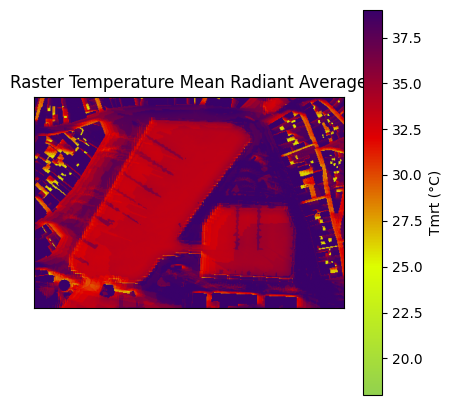

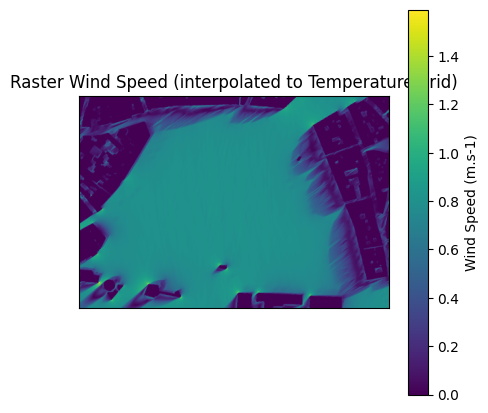

In [41]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

boundaries = [18, 21, 28, 35, 39]
colors = ['#92d14f', '#ddff00', '#e10000', '#390069']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
norm = Normalize(vmin=min(boundaries), vmax=max(boundaries))

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
img = plt.imshow(temp, cmap=cmap, norm=norm)
plt.colorbar(img, ax=ax, label='Tmrt (°C)')
plt.title('Raster Temperature Mean Radiant Average')
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xticks([])
ax.set_yticks([])
img = plt.imshow(wind_as_array)
plt.colorbar(img, ax=ax, label='Wind Speed (m.s-1)')
plt.title('Raster Wind Speed (interpolated to Temperature grid)')
plt.show()

## Calcul de l'UTCI : (Universal Thermal Climate Index)

In [42]:
src_nc = os.path.join(output_path_urock, f'output_{direction}.nc')
umep_core = UmepCore(output_dir=output_path_urock)

options_umep_urock_analyze = {
    'INPUT_LINES': None,
    'IS_STREAM': False,
    'ID_FIELD_LINES': '',
    'INPUT_POLYGONS': None,
    'ID_FIELD_POLYGONS': '',
    'INPUT_WIND_FILE': src_nc,
    'SIMULATION_NAME': '',
    'OUTPUT_DIRECTORY': output_path_urock
}
umep_core.run_processing(
    name="umep:Urban Wind Field: URock analyzer",
    options=options_umep_urock_analyze
)


__init__ QGisCore
__init__ qgsApp
platform.system() Linux
__init__ UmepCore
Processing UMEP umep:Urban Wind Field: URock analyzer
{'INPUT_LINES': None, 'IS_STREAM': False, 'ID_FIELD_LINES': '', 'INPUT_POLYGONS': None, 'ID_FIELD_POLYGONS': '', 'INPUT_WIND_FILE': '/home/inagoogle/PycharmProjects/pymdu/demos/results_demo/output_urock/output_50.nc', 'SIMULATION_NAME': '', 'OUTPUT_DIRECTORY': '/home/inagoogle/PycharmProjects/pymdu/demos/results_demo/output_urock'}


Connecting to database
	->/tmp/myDbH21751384095_2620587
/home/inagoogle/micromamba/envs/pymdu/share/qgis/python/plugins/processing_umep/functions/URock/h2gis-standalone/h2gis-dist-2.2.3.jar
Connected!

Spatial functions added!

Processing UMEP EXIT umep:Urban Wind Field: URock analyzer


In [43]:
import numpy as np
import pandas as pd
import rioxarray
from tqdm import tqdm
from pythermalcomfort.models import utci
import os


def wind_a_10m_vectorized(x):
    return x * np.log(10 / 0.01) / np.log(np.minimum(1.5, 10) / 0.01)


output_path = os.path.join(os.getcwd(), 'results_demo')
output_path_urock = os.path.join(output_path, 'output_urock')
os.makedirs(output_path_urock, exist_ok=True)

METEO_FILE = 'FRA_AC_La.Rochelle.073150_TMYx.2004-2018.txt'
METEO_DATA = pd.read_csv(METEO_FILE, sep=' ')

direction = 50
wind_velocity = 4.1
HEURE = 16

# TMRT_PATH = os.path.join(output_path, 'Tmrt_average.tif')
TMRT_PATH = os.path.join(output_path, 'Tmrt_2018_181_1660D.tif')
TMRT_dataset = rioxarray.open_rasterio(TMRT_PATH)
tmr_as_array = TMRT_dataset.data[0]
size1, size2 = tmr_as_array.shape

wind_as_array_speed = wind_velocity * wind_a_10m_vectorized(wind_as_array)

output = np.zeros(shape=(size1, size2))
tdb = METEO_DATA[METEO_DATA.it == HEURE].Td.values[0]
rh = METEO_DATA[METEO_DATA.it == HEURE].RH.values[0]
for i in tqdm(range(0, size1)):
    output[i, :] = utci(tdb=tdb, tr=tmr_as_array[i, :], v=wind_as_array_speed[i, :], rh=rh, limit_inputs=False)
UTCI_dataset = TMRT_dataset.copy()
UTCI_dataset.data[0] = output


/home/inagoogle/micromamba/envs/pymdu/lib/python3.11/site-packages/pythermalcomfort/models/jos3.py:371: DeprecationWarning: invalid escape sequence '\d'
  version_number_string = re.findall("\d+\.\d+\.\d+", version_string)[0]
100%|██████████| 309/309 [00:00<00:00, 12895.28it/s]


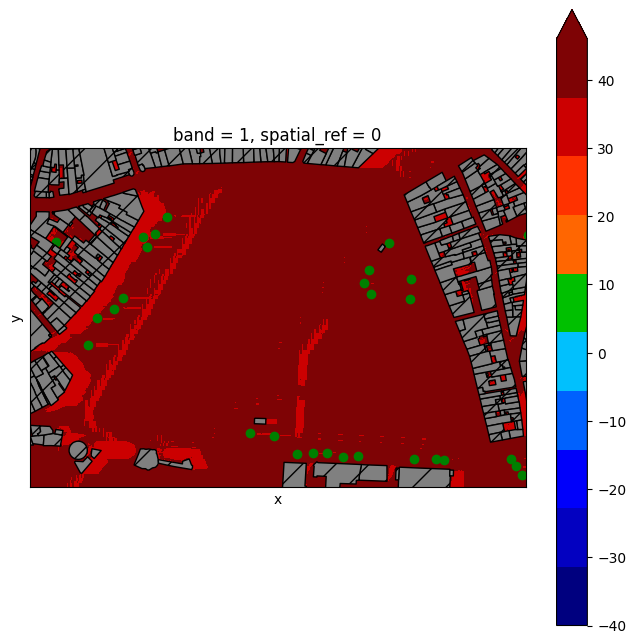

In [44]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

inputs_simulation_path = os.path.join(os.getcwd(), 'results_demo/inputs_simulation')

#boundaries = [21, 21, 28, 35, 42, 46, 53]
boundaries = [-40, -27, -13, 0, 9, 26, 32, 38, 46]
colors = ['#00007f','#0301c1','#0000fb','#0061fe','#01c0fd','#00c000','#ff6601', '#ff3200', '#cc0001', '#7e0305']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=10)
norm = Normalize(vmin=min(boundaries), vmax=max(boundaries))

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
plt.title("UTCI (Universal Thermal Climate Index)")
UTCI_dataset.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True)
lidar_trees_gdf.to_crs(2154).plot(ax=ax, color='g', alpha=1)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')
plt.show()

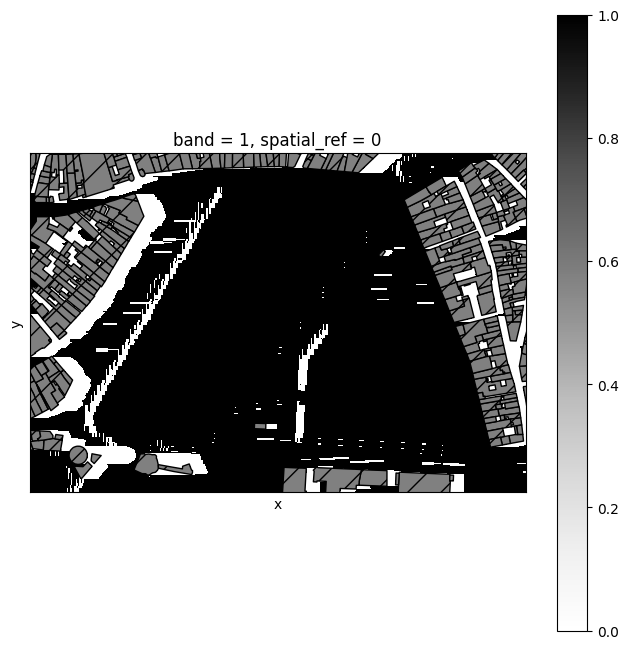

In [45]:
SHD_PATH = os.path.join(output_path, 'Shadow_2018_181_1660D.tif')
SHD_dataset = rioxarray.open_rasterio(SHD_PATH)
shading_mask = SHD_dataset.data[0]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
SHD_dataset.plot(ax=ax, cmap = 'Greys')
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')
plt.show()

In [46]:
utci_out = UTCI_dataset.data[0].copy()

shadow_matrix = np.where(shading_mask == 0, utci_out, np.nan)
UTCI_shadow = UTCI_dataset.copy()
UTCI_shadow.data[0] = shadow_matrix


sun_matrix = np.where(shading_mask > 0.5, utci_out, np.nan)
UTCI_sun = UTCI_dataset.copy()
UTCI_sun.data[0] = sun_matrix


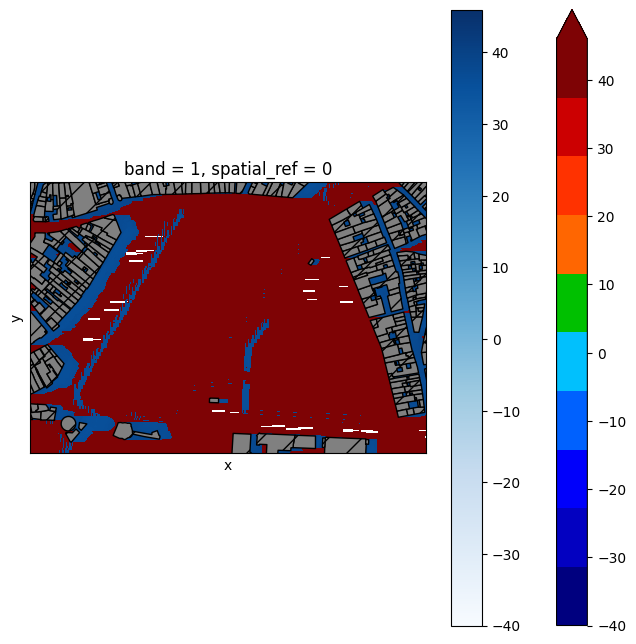

In [47]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

inputs_simulation_path = os.path.join(os.getcwd(), 'results_demo/inputs_simulation')

#boundaries = [21, 21, 28, 35, 42, 46, 53]
boundaries = [-40, -27, -13, 0, 9, 26, 32, 38, 46]
colors = ['#00007f','#0301c1','#0000fb','#0061fe','#01c0fd','#00c000','#ff6601', '#ff3200', '#cc0001', '#7e0305']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=10)
norm = Normalize(vmin=min(boundaries), vmax=max(boundaries))



fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
plt.title("UTCI (Universal Thermal Climate Index)")
UTCI_sun.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True)
UTCI_shadow.plot(ax=ax, cmap='Blues', norm=norm, add_colorbar=True)
# lidar_trees_gdf.to_crs(2154).plot(ax=ax, color='g', alpha=1)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')
plt.show()

In [48]:
import rasterio
import geopandas as gpd
from rasterio.features import rasterize

# use template
with rasterio.open(SHD_PATH) as src:
    meta = src.meta.copy()
    out_shape = src.shape
    transform = src.transform
    crs = src.crs

# zone pieton
zone_imperm = cosia_gdf[cosia_gdf['classe'] == 'Zone imperméable']

# We'll use 1 for imperméable, 0 for everything else
shapes = ((geom, 1) for geom in zone_imperm.geometry)

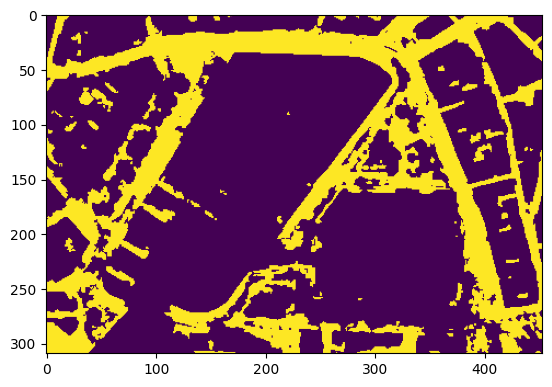

In [49]:
import numpy as np

# Create a raster of zeros
out_arr = np.zeros(out_shape, dtype='uint8')

# Rasterize
imperm_raster = rasterize(
    shapes=shapes,
    out_shape=out_shape,
    transform=transform,
    fill=0,               # Fill value for non-imperm zones
    all_touched=True,     # Optional: True means touching pixels will be filled; False is more conservative
    dtype='uint8'
)

plt.imshow(imperm_raster)
plt.show()

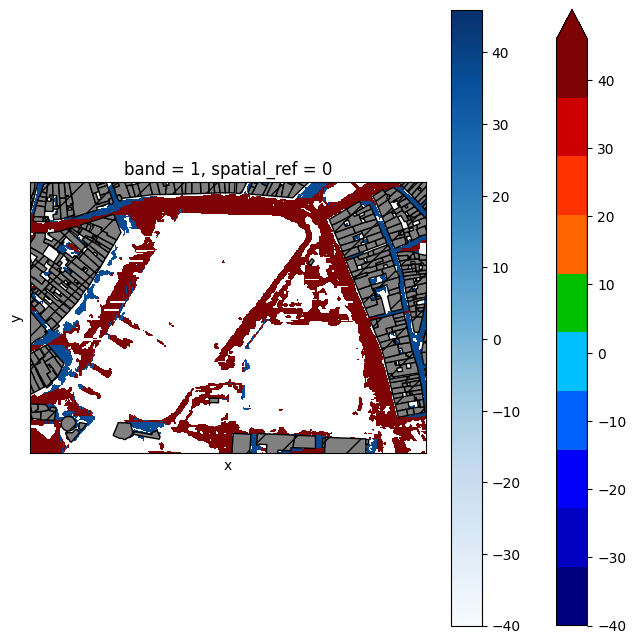

In [53]:
utci_output_shadow = UTCI_shadow.data[0].copy()
shadow_matrix_pedestrian = np.where(imperm_raster == 1, utci_output_shadow, np.nan)
UTCI_shadow_pedestrian = UTCI_shadow.copy()
UTCI_shadow_pedestrian.data[0] = shadow_matrix_pedestrian

utci_output_sun = UTCI_sun.data[0].copy()
sun_matrix_pedestrian = np.where(imperm_raster == 1, utci_output_sun, np.nan)
UTCI_sun_pedestrian = UTCI_sun.copy()
UTCI_sun_pedestrian.data[0] = sun_matrix_pedestrian

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
plt.title("UTCI (Universal Thermal Climate Index) in pedestrian area sun/shadow")
UTCI_sun_pedestrian.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True)
UTCI_shadow_pedestrian.plot(ax=ax, cmap='Blues', norm=norm, add_colorbar=True)
# lidar_trees_gdf.to_crs(2154).plot(ax=ax, color='g', alpha=1)
buildings_gdf.plot(ax=ax, color='grey', edgecolor='k', hatch='/')
plt.show()

In [54]:
def PPD_pmv(PMV):
    """
    PPD = f(PMV)
    """
    # PMV = np.max(0, PMV)
    PMV = np.clip(PMV, 0, None)
    return (100 - 95 * np.exp(-0.03353 * PMV ** 4 - 0.2179 * PMV ** 2))


# 2. Une interpolation linéaire PMV = f(UTCI)
def UTCI_to_PMV(UTCI,
                limPMV=[0.5, 3],
                limUTCI=[26, 42]):
    """
    UTCI = f(PMV)
    """
    return ((limPMV[1] - limPMV[0]) * (UTCI - limUTCI[0]) / (limUTCI[1] - limUTCI[0]) + limPMV[0])


# 3. Une interpolation linéraire PPD = f(%ombre)
def PPD_shad(shad,
             limShad=[100, 0],
             limPMV=[0.5, 3]):
    """
    PPD_shadows = f(shadow)
    """
    PMVeqShad = limPMV[1] - (limPMV[1] - limPMV[0]) * (100 * shad - limShad[1]) / (limShad[0] - limShad[1])

    return (PPD_pmv(PMVeqShad))

In [55]:
shadow_policy = 1
shadow_pct = np.count_nonzero(~np.isnan(UTCI_shadow_pedestrian.data[0])) / np.sum(imperm_raster)

utci_sun = np.nanmean(UTCI_sun_pedestrian.data[0])
utci_shadow = np.nanmean(UTCI_shadow_pedestrian.data[0])
print('Mean UTCI in the pedestrian zone with sun :' , utci_sun, '\nMean UTCI in the pedestrian zone with shadow :', utci_shadow)

PPD_UTCI_etoile = PPD_pmv(UTCI_to_PMV(utci_sun))/100
PPD_UTCI_chapeau = PPD_pmv(UTCI_to_PMV(utci_shadow))/100
print('PPD_UTCI_etoile = ', PPD_UTCI_etoile, ', PPD_UTCI_chapeau = ', PPD_UTCI_chapeau)

f_fchap = max(min(shadow_pct/shadow_policy, 1),0)

MIN_TERME = min(f_fchap, PPD_UTCI_etoile)

PPD_INDICATOR = (PPD_UTCI_etoile-MIN_TERME)+min(max(0, PPD_UTCI_chapeau - (PPD_UTCI_etoile-MIN_TERME)), f_fchap)
print('PPD_INDICATOR = ', PPD_INDICATOR)

Mean UTCI in the pedestrian zone with sun : 44.289505 
Mean UTCI in the pedestrian zone with shadow : 37.286488
PPD_UTCI_etoile =  0.9988523505410061 , PPD_UTCI_chapeau =  0.8709908110662659
PPD_INDICATOR =  0.8709908110662659
